<a href="https://colab.research.google.com/github/emrapport/w266-final-project/blob/master/LP_hyperparam_experiments_max_seq2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total 10 models; this notebook has 4 to ??. MAX_SEQUENCE_LENGTH: {10,20,30,50,100} and for each sample first words in one model and  half first, half last in a second model. Constant 2 layers, 32 layer size, 2 filter size, .2 dropout rate, drop 1-2 word responses, max 50 responses per post.

In [0]:
# name of subfolder under models/ where trained models should go
MODEL_PREFIX = "LPFriday11_22"

hyp_combos = [{'NUM_EPOCHS': 10,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 20,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                'NUM_LAYERS': 2,
                'CONV_LAYER_SIZES': [32,32],
                'FILTER_SIZES': [2,2],
                'DROPOUT_RATES': [.2,.2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':0,
                'SAMPLE_FROM_BEG_AND_END':False},
              
                {'NUM_EPOCHS': 10,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 30,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                'NUM_LAYERS': 2,
                'CONV_LAYER_SIZES': [32,32],
                'FILTER_SIZES': [2,2],
                'DROPOUT_RATES': [.2,.2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':0,
                'SAMPLE_FROM_BEG_AND_END':True},
              
                {'NUM_EPOCHS': 10,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 30,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                'NUM_LAYERS': 2,
                'CONV_LAYER_SIZES': [32,32],
                'FILTER_SIZES': [2,2],
                'DROPOUT_RATES': [.2,.2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':0,
                'SAMPLE_FROM_BEG_AND_END':False},
              
                {'NUM_EPOCHS': 10,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 50,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                'NUM_LAYERS': 2,
                'CONV_LAYER_SIZES': [32,32],
                'FILTER_SIZES': [2,2],
                'DROPOUT_RATES': [.2,.2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':0,
                'SAMPLE_FROM_BEG_AND_END':True},
              
                {'NUM_EPOCHS': 10,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 50,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                'NUM_LAYERS': 2,
                'CONV_LAYER_SIZES': [32,32],
                'FILTER_SIZES': [2,2],
                'DROPOUT_RATES': [.2,.2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':0,
                'SAMPLE_FROM_BEG_AND_END':False},
              
                {'NUM_EPOCHS': 10,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 100,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                'NUM_LAYERS': 2,
                'CONV_LAYER_SIZES': [32,32],
                'FILTER_SIZES': [2,2],
                'DROPOUT_RATES': [.2,.2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':0,
                'SAMPLE_FROM_BEG_AND_END':True},
              
                {'NUM_EPOCHS': 10,
                'BATCH_SIZE': 1000,
                'MAX_SEQUENCE_LENGTH': 100,
                'N_MOST_FREQ_WORDS_TO_KEEP': 5000,
                'MAX_RESPONSES_PER_POST': 50,
                'NUM_LAYERS': 2,
                'CONV_LAYER_SIZES': [32,32],
                'FILTER_SIZES': [2,2],
                'DROPOUT_RATES': [.2,.2],
                'FINAL_DENSE_LAYER_SIZE': 10,
                # embed dim needs to map to one of the glove versions: 50, 100, 200, 300 
                'EMBEDDING_DIM': 50,
                'REMOVE_SHORT_RESP_LENGTH':0,
                'SAMPLE_FROM_BEG_AND_END':False}
                ]

In [0]:
## check to ensure hyps are in agreement
for hyp_combo in hyp_combos:
  assert hyp_combo['NUM_LAYERS'] == len(hyp_combo['CONV_LAYER_SIZES'])
  assert hyp_combo['NUM_LAYERS'] == len(hyp_combo['FILTER_SIZES'])
  assert hyp_combo['NUM_LAYERS'] == len(hyp_combo['DROPOUT_RATES'])

In [3]:
## all this stuff just needs to get run one time per notebook
# Set seeds for reproducible results.
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer
from keras.preprocessing.sequence import pad_sequences
from scipy.sparse import hstack, vstack
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential, layers
from keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import time
import pickle
!pip install gcsfs

pd.set_option('max_colwidth', 100)

project_id = 'w266-251323'
import uuid
bucket_name = 'fb-congressional-data/'
from google.colab import auth
auth.authenticate_user()
!gcloud config set project {project_id}


Using TensorFlow backend.


Updated property [core/project].


In [4]:
train_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/train.csv", index_col=0)
dev_df = pd.read_csv("gs://fb-congressional-data/contraction_expanded_data/dev.csv", index_col=0)
!gsutil cp gs://fb-congressional-data/glove* /tmp/

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Copying gs://fb-congressional-data/glove.6B.100d.txt...
Copying gs://fb-congressional-data/glove.6B.200d.txt...
Copying gs://fb-congressional-data/glove.6B.300d.txt...
Copying gs://fb-congressional-data/glove.6B.50d.txt...
- [4 files][  2.1 GiB/  2.1 GiB]   45.5 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://fb-congressional-data/glove.6B.zip...
- [5 files][  2.9 GiB/  2.9 GiB]   46.9 MiB/s                                   
Operation completed over 5 objects/2.9 GiB.                                      


In [0]:
# all the functions go here
def remove_excess_rows_per_post(df, max_per_post):
  num_responses_per_post = df.post_id.value_counts().reset_index()
  num_responses_per_post.columns = ['post_id', 'num_responses']
  
  too_big_posts = num_responses_per_post[num_responses_per_post.num_responses > max_per_post]
  posts_to_sample = too_big_posts.post_id.values
  
  # this gets all the rows for posts we DON'T need to sample 
  new_train_df = df[~df.post_id.isin(posts_to_sample)]
  # this should be true
  assert(len(too_big_posts) + new_train_df.post_id.nunique() == df.post_id.nunique())
  
  too_big_post_rows = df[df.post_id.isin(posts_to_sample)]
  sampled_rows = too_big_post_rows.groupby('post_id').apply(lambda x: x.sample(n=max_per_post)).reset_index(drop=True)
  new_train_df = pd.concat([new_train_df, sampled_rows])
  
  return new_train_df

def get_labels(train_df, test_df, party_label_ind):

  def turn_to_ints(li):
    final_list = []
    for gender in li:
        if gender=='M':
            final_list.append(1)
        else:
            final_list.append(0)
    male = sum(final_list)
    female = len(final_list)-sum(final_list)
    percent_male = sum(final_list)/len(final_list)
    print('total M: {}, total W: {}, percent M: {}'.format(male,female,percent_male))
    return final_list

  def turn_to_ints_party(li):
    final_list = []
    for party in li:
        if party=='Congress_Republican':
            final_list.append(1)
        else:
            final_list.append(0)
    republican = sum(final_list)
    not_repub = len(final_list)-sum(final_list)
    percent_repub = sum(final_list)/len(final_list)
    print('total republican: {}, total not republican: {}, percent republican: {}'.format(republican,not_repub,percent_repub))
    return final_list

  if party_label_ind:

    y_train = train_df.op_category.values
    y_dev = test_df.op_category.values
    print('training set:')
    y_train = turn_to_ints_party(y_train)
    print('dev set:')
    y_dev = turn_to_ints_party(y_dev) 

  else:
    y_train = train_df.op_gender.values
    y_dev = test_df.op_gender.values
    print('training set:')
    y_train = turn_to_ints(y_train)
    print('dev set:')
    y_dev = turn_to_ints(y_dev)

  y_train = np.asarray(y_train)
  y_dev = np.asarray(y_dev)

  return y_train, y_dev

def get_inputs(train_df, 
               test_df, 
               party_train_df,
               party_dev_df,
               n_words_to_keep,
               max_seq_length):
  def get_text_list(init_list):
      sentences = []
      for sentence in init_list:
          if type(sentence) != str:
              sentences.append("")
          else:
              sentences.append(sentence)
      return sentences

  new_sentences_train = get_text_list(train_df.response_text.values)
  new_sentences_test = get_text_list(dev_df.response_text.values)
  party_new_sentences_train = get_text_list(party_train_df.response_text.values)
  party_new_sentences_test = get_text_list(party_dev_df.response_text.values)

  time_start = time.time()

  # this is the default list of filters + apostrophe
  # added because we have dealt with common contractions, so other apostrophes should mostly be possessive 
  tokenizer = Tokenizer(filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token='UNK')
  tokenizer.fit_on_texts(new_sentences_train)


  currentTime = time.gmtime(time.time() - time_start)

  #Convert the gmtime struct to a string
  timeStr = time.strftime("%M minutes, %S seconds", currentTime)

  print("Tokenized in {}".format(timeStr))

  # suggestion from this issue: https://github.com/keras-team/keras/issues/8092
  # seems like OOV and num_words don't work correctly by default 
  tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() 
                              if i <= n_words_to_keep + 1} 
  tokenizer.word_index[tokenizer.oov_token] = n_words_to_keep + 1

  X_train = tokenizer.texts_to_sequences(new_sentences_train)
  X_test = tokenizer.texts_to_sequences(new_sentences_test)
  X_train = pad_sequences(X_train, padding='post', maxlen=max_seq_length)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_seq_length)

  X_train_party = tokenizer.texts_to_sequences(party_new_sentences_train)
  X_test_party = tokenizer.texts_to_sequences(party_new_sentences_test)
  X_train_party = pad_sequences(X_train_party, padding='post', maxlen=max_seq_length)
  X_test_party = pad_sequences(X_test_party, padding='post', maxlen=max_seq_length)
  return X_train, X_test, X_train_party, X_test_party, tokenizer

def create_embedding_matrix(filepath, 
                            word_index, 
                            embedding_dim):
    vocab_size = len(word_index) + 2  # Now we have to add 2 (reserved 0 plus the manual UNK token)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

def make_model(embedding_matrix, 
               max_seq_length,
               num_layers,
               conv_layer_size,
               filter_size,
               dropout_rate,
               final_hidden_dense_size):
  model = Sequential()

  try:
    model.add(layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                              weights=[embedding_matrix], 
                              input_length=max_seq_length, 
                              trainable=False))
    for i in range(num_layers):
      model.add(layers.Conv1D(conv_layer_size[i], filter_size[i], activation='relu', padding="same"))
      model.add(layers.Dropout(dropout_rate[i]))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(final_hidden_dense_size, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
  except Exception as ex:
    print(ex)
  finally:
    return model

def train_model(model, 
                train_inputs,
                dev_inputs,
                train_labels,
                dev_labels,
                num_epochs,
                batch_size):
  try:
    time_start = time.time()

    history = model.fit(train_inputs, train_labels,
                        epochs=num_epochs,
                        verbose=True,
                        validation_data=(dev_inputs, dev_labels),
                        batch_size=batch_size)

    currentTime = time.gmtime(time.time() - time_start)

    #Convert the gmtime struct to a string
    timeStr = time.strftime("%M minutes, %S seconds", currentTime)

    print("Trained in {}".format(timeStr))

  except Exception as ex:
    print("Exception: {}".format(ex))
    currentTime = time.gmtime(time.time() - time_start)

    #Convert the gmtime struct to a string
    timeStr = time.strftime("%M minutes, %S seconds", currentTime)

    print("Trained in {}".format(timeStr))  
  finally:
    return model

def pred_to_label(row):
  if row['probs'] >= .5:
    return 'M'
  else:
    return 'W'

def pred_to_party_label(row):
  if row['probs2'] >= .5:
    return 'Congress_Republican'
  else:
    return 'Not_Republican'

def remove_short_responses(responses_df,n):
  '''Takes a dataframe that includes a response_text column and removes 
  responses shorter than or equal to n. Returns new dataframe.'''
  responses_df['split_response'] = responses_df['response_text'].str.split()
  mask = (responses_df['split_response'].str.len() > n)
  responses_df = responses_df.loc[mask]
  responses_df = responses_df.drop(columns='split_response', axis = 1)
  return responses_df

def shorten_single_response(series_list,length):
  '''Take a list of strings and a goal max length. Return the goal length list
  taken half from the beginning of the orginal list and half from the end of 
  the original list.'''
  if type(series_list) != float:
    if len(series_list) > length:
      new_list = series_list[:(length//2+length % 2)] + series_list[-length//2:]
      return new_list
    else: 
      return series_list
  else:
    return series_list

def get_beg_end_responses(responses_df,n):
  '''Takes a dataframe that includes a response_text column, creates new
  response_text strings of word length n using the first n/2 words and last n/2
  words of the response_text and returns a new dataframe with the new response_text.'''
  responses_df['split_response'] = responses_df['response_text'].str.split()
  responses_df['short_response'] = responses_df['split_response'].apply(shorten_single_response,args=(n,))
  responses_df['response_text'] = responses_df['short_response'].str.join(' ')
  responses_df = responses_df.drop(columns=['split_response','short_response'], axis=1)
  return responses_df


Training Model 0
Limiting to 50 responses per post resulted in 3962284 training rows
Responses include only the first 20 words
Getting labels
training set:
total M: 2900753, total W: 1061531, percent M: 0.7320911373339215
dev set:
total M: 1948371, total W: 344536, percent M: 0.8497383452534272
training set:
total republican: 2459013, total not republican: 1486355, percent republican: 0.623265814494364
dev set:
total republican: 1698252, total not republican: 594655, percent republican: 0.7406545490070029
Getting inputs
Tokenized in 02 minutes, 20 seconds
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Para

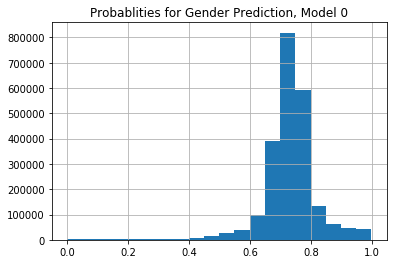

Train on 3945368 samples, validate on 2292907 samples
Epoch 1/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.6232 - acc: 0.6516 - val_loss: 0.5786 - val_acc: 0.7368
Epoch 2/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5977 - acc: 0.6706 - val_loss: 0.5693 - val_acc: 0.7388
Epoch 3/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5921 - acc: 0.6744 - val_loss: 0.5670 - val_acc: 0.7417
Epoch 4/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5892 - acc: 0.6761 - val_loss: 0.5621 - val_acc: 0.7464
Epoch 5/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5873 - acc: 0.6769 - val_loss: 0.5595 - val_acc: 0.7474
Epoch 6/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5858 - acc: 0.6780 - val_loss: 0.5581 - val_acc: 0.7477
Epoch 7/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5

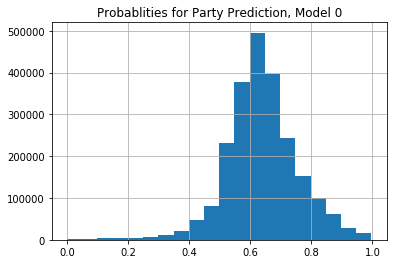

Training Model 1
Limiting to 50 responses per post resulted in 3962284 training rows
Responses include only the first 15 and last 15 words
Getting labels
training set:
total M: 2900753, total W: 1061531, percent M: 0.7320911373339215
dev set:
total M: 1948371, total W: 344536, percent M: 0.8497383452534272
training set:
total republican: 2459013, total not republican: 1486355, percent republican: 0.623265814494364
dev set:
total republican: 1698252, total not republican: 594655, percent republican: 0.7406545490070029
Getting inputs
Tokenized in 01 minutes, 44 seconds
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 50)            250150    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 32)            3232      
_________________________________________________________________
dropout_

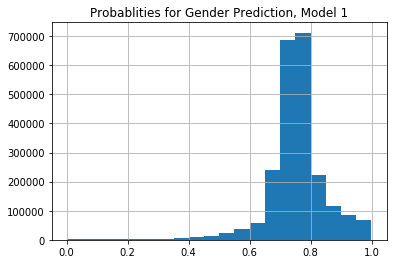

Train on 3945368 samples, validate on 2292907 samples
Epoch 1/10
3945368/3945368 [==============================] - 25s 6us/sample - loss: 0.6001 - acc: 0.6676 - val_loss: 0.5774 - val_acc: 0.7378
Epoch 2/10
3945368/3945368 [==============================] - 25s 6us/sample - loss: 0.5735 - acc: 0.6863 - val_loss: 0.5794 - val_acc: 0.7330
Epoch 3/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5681 - acc: 0.6902 - val_loss: 0.5665 - val_acc: 0.7431
Epoch 4/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5654 - acc: 0.6919 - val_loss: 0.5718 - val_acc: 0.7414
Epoch 5/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5637 - acc: 0.6930 - val_loss: 0.5616 - val_acc: 0.7454
Epoch 6/10
3945368/3945368 [==============================] - 25s 6us/sample - loss: 0.5625 - acc: 0.6936 - val_loss: 0.5712 - val_acc: 0.7404
Epoch 7/10
3945368/3945368 [==============================] - 25s 6us/sample - loss: 0.5

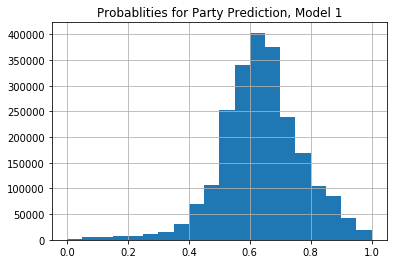

Training Model 2
Limiting to 50 responses per post resulted in 3962284 training rows
Responses include only the first 30 words
Getting labels
training set:
total M: 2900753, total W: 1061531, percent M: 0.7320911373339215
dev set:
total M: 1948371, total W: 344536, percent M: 0.8497383452534272
training set:
total republican: 2459013, total not republican: 1486355, percent republican: 0.623265814494364
dev set:
total republican: 1698252, total not republican: 594655, percent republican: 0.7406545490070029
Getting inputs
Tokenized in 02 minutes, 20 seconds
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 50)            250150    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 30, 32)            3232      
_________________________________________________________________
dropout_8 (Dropout) 

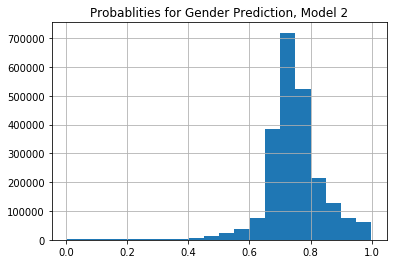

Train on 3945368 samples, validate on 2292907 samples
Epoch 1/10
3945368/3945368 [==============================] - 25s 6us/sample - loss: 0.6114 - acc: 0.6594 - val_loss: 0.5655 - val_acc: 0.7434
Epoch 2/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5863 - acc: 0.6770 - val_loss: 0.5669 - val_acc: 0.7415
Epoch 3/10
3945368/3945368 [==============================] - 25s 6us/sample - loss: 0.5814 - acc: 0.6805 - val_loss: 0.5758 - val_acc: 0.7379
Epoch 4/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5788 - acc: 0.6822 - val_loss: 0.5775 - val_acc: 0.7344
Epoch 5/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5773 - acc: 0.6831 - val_loss: 0.5729 - val_acc: 0.7374
Epoch 6/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5762 - acc: 0.6840 - val_loss: 0.5857 - val_acc: 0.7267
Epoch 7/10
3945368/3945368 [==============================] - 24s 6us/sample - loss: 0.5

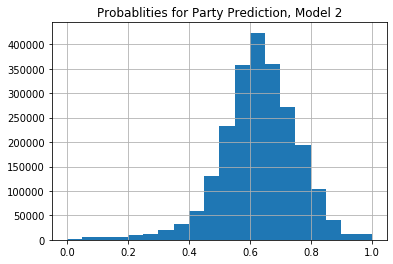

Training Model 3
Limiting to 50 responses per post resulted in 3962284 training rows
Responses include only the first 25 and last 25 words
Getting labels
training set:
total M: 2900753, total W: 1061531, percent M: 0.7320911373339215
dev set:
total M: 1948371, total W: 344536, percent M: 0.8497383452534272
training set:
total republican: 2459013, total not republican: 1486355, percent republican: 0.623265814494364
dev set:
total republican: 1698252, total not republican: 594655, percent republican: 0.7406545490070029
Getting inputs
Tokenized in 01 minutes, 50 seconds
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 50)            250150    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 50, 32)            3232      
_________________________________________________________________
dropout_

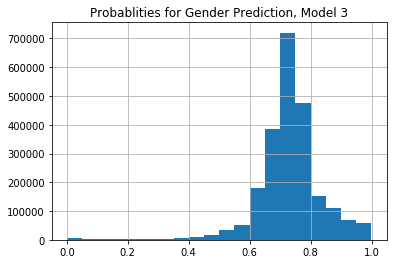

Train on 3945368 samples, validate on 2292907 samples
Epoch 1/10
3945368/3945368 [==============================] - 29s 7us/sample - loss: 0.6018 - acc: 0.6669 - val_loss: 0.5969 - val_acc: 0.7191
Epoch 2/10
3945368/3945368 [==============================] - 28s 7us/sample - loss: 0.5721 - acc: 0.6871 - val_loss: 0.5862 - val_acc: 0.7224
Epoch 3/10
3945368/3945368 [==============================] - 28s 7us/sample - loss: 0.5660 - acc: 0.6913 - val_loss: 0.5649 - val_acc: 0.7341
Epoch 4/10
3945368/3945368 [==============================] - 28s 7us/sample - loss: 0.5632 - acc: 0.6930 - val_loss: 0.5562 - val_acc: 0.7406
Epoch 5/10
3945368/3945368 [==============================] - 28s 7us/sample - loss: 0.5616 - acc: 0.6941 - val_loss: 0.5561 - val_acc: 0.7322
Epoch 6/10
3945368/3945368 [==============================] - 28s 7us/sample - loss: 0.5603 - acc: 0.6948 - val_loss: 0.5722 - val_acc: 0.7283
Epoch 7/10
3945368/3945368 [==============================] - 29s 7us/sample - loss: 0.5

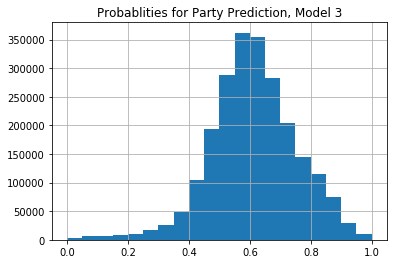

Training Model 4
Limiting to 50 responses per post resulted in 3962284 training rows
Responses include only the first 50 words
Getting labels
training set:
total M: 2900753, total W: 1061531, percent M: 0.7320911373339215
dev set:
total M: 1948371, total W: 344536, percent M: 0.8497383452534272
training set:
total republican: 2459013, total not republican: 1486355, percent republican: 0.623265814494364
dev set:
total republican: 1698252, total not republican: 594655, percent republican: 0.7406545490070029
Getting inputs
Tokenized in 02 minutes, 21 seconds
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 50)            250150    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 50, 32)            3232      
_________________________________________________________________
dropout_16 (Dropout)

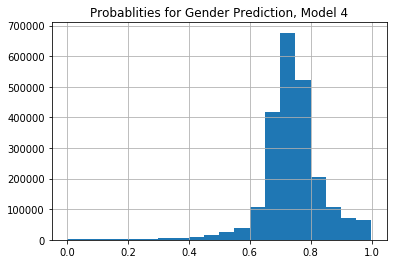

Train on 3945368 samples, validate on 2292907 samples
Epoch 1/10
3945368/3945368 [==============================] - 30s 8us/sample - loss: 0.6056 - acc: 0.6641 - val_loss: 0.5751 - val_acc: 0.7386
Epoch 2/10
3945368/3945368 [==============================] - 29s 7us/sample - loss: 0.5788 - acc: 0.6831 - val_loss: 0.5754 - val_acc: 0.7402
Epoch 3/10
3945368/3945368 [==============================] - 28s 7us/sample - loss: 0.5732 - acc: 0.6867 - val_loss: 0.5800 - val_acc: 0.7375
Epoch 4/10
3945368/3945368 [==============================] - 29s 7us/sample - loss: 0.5702 - acc: 0.6886 - val_loss: 0.5743 - val_acc: 0.7410
Epoch 5/10
3945368/3945368 [==============================] - 29s 7us/sample - loss: 0.5686 - acc: 0.6895 - val_loss: 0.5755 - val_acc: 0.7430
Epoch 6/10
3945368/3945368 [==============================] - 29s 7us/sample - loss: 0.5672 - acc: 0.6902 - val_loss: 0.5780 - val_acc: 0.7391
Epoch 7/10
3945368/3945368 [==============================] - 29s 7us/sample - loss: 0.5

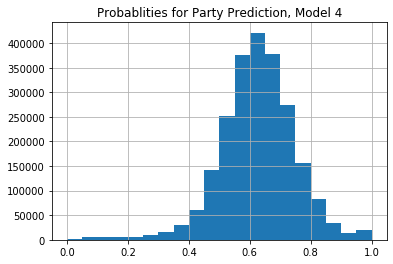

Training Model 5
Limiting to 50 responses per post resulted in 3962284 training rows
Responses include only the first 50 and last 50 words
Getting labels
training set:
total M: 2900753, total W: 1061531, percent M: 0.7320911373339215
dev set:
total M: 1948371, total W: 344536, percent M: 0.8497383452534272
training set:
total republican: 2459013, total not republican: 1486355, percent republican: 0.623265814494364
dev set:
total republican: 1698252, total not republican: 594655, percent republican: 0.7406545490070029
Getting inputs
Tokenized in 02 minutes, 08 seconds
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 50)           250150    
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 100, 32)           3232      
_________________________________________________________________
dropout

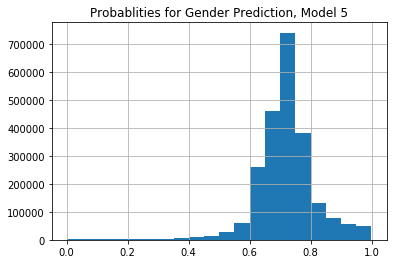

Train on 3945368 samples, validate on 2292907 samples
Epoch 1/10
3945368/3945368 [==============================] - 39s 10us/sample - loss: 0.5966 - acc: 0.6708 - val_loss: 0.6352 - val_acc: 0.6962
Epoch 2/10
3945368/3945368 [==============================] - 38s 10us/sample - loss: 0.5701 - acc: 0.6884 - val_loss: 0.5752 - val_acc: 0.7384
Epoch 3/10
3945368/3945368 [==============================] - 38s 10us/sample - loss: 0.5645 - acc: 0.6920 - val_loss: 0.5735 - val_acc: 0.7347
Epoch 4/10
3945368/3945368 [==============================] - 38s 10us/sample - loss: 0.5615 - acc: 0.6940 - val_loss: 0.5669 - val_acc: 0.7388
Epoch 5/10
3945368/3945368 [==============================] - 38s 10us/sample - loss: 0.5598 - acc: 0.6953 - val_loss: 0.5700 - val_acc: 0.7381
Epoch 6/10
3945368/3945368 [==============================] - 38s 10us/sample - loss: 0.5585 - acc: 0.6959 - val_loss: 0.5756 - val_acc: 0.7327
Epoch 7/10
3945368/3945368 [==============================] - 38s 10us/sample - lo

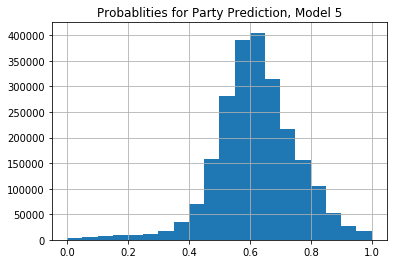

Training Model 6
Limiting to 50 responses per post resulted in 3962284 training rows
Responses include only the first 100 words
Getting labels
training set:
total M: 2900753, total W: 1061531, percent M: 0.7320911373339215
dev set:
total M: 1948371, total W: 344536, percent M: 0.8497383452534272
training set:
total republican: 2459013, total not republican: 1486355, percent republican: 0.623265814494364
dev set:
total republican: 1698252, total not republican: 594655, percent republican: 0.7406545490070029
Getting inputs
Tokenized in 02 minutes, 20 seconds
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 50)           250150    
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 100, 32)           3232      
_________________________________________________________________
dropout_24 (Dropou

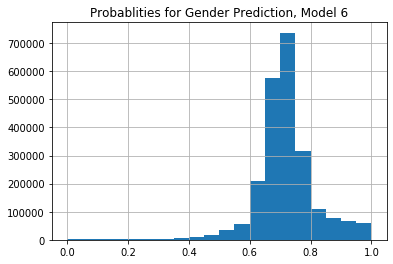

Train on 3945368 samples, validate on 2292907 samples
Epoch 1/10
3945368/3945368 [==============================] - 39s 10us/sample - loss: 0.5964 - acc: 0.6705 - val_loss: 0.6022 - val_acc: 0.7069
Epoch 2/10
3945368/3945368 [==============================] - 39s 10us/sample - loss: 0.5710 - acc: 0.6884 - val_loss: 0.5887 - val_acc: 0.7118
Epoch 3/10
3945368/3945368 [==============================] - 38s 10us/sample - loss: 0.5660 - acc: 0.6919 - val_loss: 0.5888 - val_acc: 0.7094
Epoch 4/10
3945368/3945368 [==============================] - 39s 10us/sample - loss: 0.5634 - acc: 0.6934 - val_loss: 0.5777 - val_acc: 0.7184
Epoch 5/10
2272000/3945368 [================>.............] - ETA: 12s - loss: 0.5620 - acc: 0.6942Buffered data was truncated after reaching the output size limit.

In [6]:
# timestamp is shared across all runs
timestamp = time.time()
for i, hyp_dict in enumerate(hyp_combos):
  print("Training Model {}".format(i))
  new_train_df = remove_excess_rows_per_post(train_df, hyp_dict['MAX_RESPONSES_PER_POST'])
  print("Limiting to {} responses per post resulted in {} training rows".format(hyp_dict['MAX_RESPONSES_PER_POST'],new_train_df.shape[0]))
  if hyp_dict['REMOVE_SHORT_RESP_LENGTH'] > 0:
    new_train_df = remove_short_responses(new_train_df,hyp_dict['REMOVE_SHORT_RESP_LENGTH'])
    dev_df =remove_short_responses(dev_df,hyp_dict['REMOVE_SHORT_RESP_LENGTH'])
    print("Removing responses under {} words resulted in {} training rows".format((hyp_dict['REMOVE_SHORT_RESP_LENGTH']+1),new_train_df.shape[0]))
    ######### Add if using test data###########
    # test_df = remove_short_responses(test_df,hyp_dict['REMOVE_SHORT_RESP_LENGTH'])
    ###########################################
  if hyp_dict['SAMPLE_FROM_BEG_AND_END']:
    length = hyp_dict['MAX_SEQUENCE_LENGTH']
    new_train_df = get_beg_end_responses(new_train_df,length)
    dev_df = get_beg_end_responses(dev_df,length)
    ######### Add if using test data###########
    # test_df = get_beg_end_responses(test_df,length)
    ###########################################
    print("Responses include only the first {} and last {} words".format((length//2+length%2),length//2))
  else:
    print("Responses include only the first {} words".format(hyp_dict['MAX_SEQUENCE_LENGTH']))

  new_train_df = new_train_df.sample(frac=1)
  dev_df = dev_df.sample(frac=1)

  party_train_df = new_train_df[new_train_df.op_category!='Congress_Independent']
  party_dev_df = dev_df[dev_df.op_category!='Congress_Independent']

  # get two sets of labels: gender and party
  print("Getting labels")
  y_train_gender, y_dev_gender = get_labels(new_train_df, dev_df, False)
  y_train_party, y_dev_party = get_labels(party_train_df, party_dev_df, True)

  print("Getting inputs")
  X_train, X_test, X_train_party, X_test_party, tokenizer = get_inputs(new_train_df, 
                                                                       dev_df, 
                                                                       party_train_df,
                                                                       party_dev_df,
                                                                       hyp_dict['N_MOST_FREQ_WORDS_TO_KEEP'], 
                                                                       hyp_dict['MAX_SEQUENCE_LENGTH'])
  embedding_matrix = create_embedding_matrix(
                     '/tmp/glove.6B.{}d.txt'.format(hyp_dict['EMBEDDING_DIM']),
                      tokenizer.word_index, hyp_dict['EMBEDDING_DIM'])
  
  # gender model
  model = make_model(embedding_matrix, 
                     hyp_dict['MAX_SEQUENCE_LENGTH'],
                     hyp_dict['NUM_LAYERS'],
                     hyp_dict['CONV_LAYER_SIZES'],
                     hyp_dict['FILTER_SIZES'],
                     hyp_dict['DROPOUT_RATES'],
                     hyp_dict['FINAL_DENSE_LAYER_SIZE'])
  print(model.summary())
  trained_model = train_model(model,
                              X_train,
                              X_test,
                              y_train_gender,
                              y_dev_gender,
                              hyp_dict['NUM_EPOCHS'],
                              hyp_dict['BATCH_SIZE']
                              )
  
  # adding epoch time just in case we accidentally re-use the same prefixes 
  gender_model_path = '{}_model_{}_gender_{}.h5'.format(MODEL_PREFIX, i, timestamp)
  model.save(gender_model_path)
  !gsutil cp /content/{gender_model_path} gs://fb-congressional-data/models/{gender_model_path}

  preds = model.predict(X_test)
  dev_df['probs'] = preds
  dev_df['preds'] = dev_df.apply(pred_to_label, axis=1)

  if 'W' in dev_df.preds.value_counts():
    proportion_women_predicted = dev_df.preds.value_counts()['W'] / len(dev_df)
  else:
    proportion_women_predicted = 0
  print("Proportion of predictions for W class: {}".format(proportion_women_predicted))
  plt.figure()
  plt.title('Probablities for Gender Prediction, Model {}'.format(i))
  dev_df.probs.hist(bins=20)
  plt.show()

  # party model
  model2 = make_model(embedding_matrix, 
                      hyp_dict['MAX_SEQUENCE_LENGTH'],
                      hyp_dict['NUM_LAYERS'],
                      hyp_dict['CONV_LAYER_SIZES'],
                      hyp_dict['FILTER_SIZES'],
                      hyp_dict['DROPOUT_RATES'],
                      hyp_dict['FINAL_DENSE_LAYER_SIZE'])
  trained_model2 = train_model(model2,
                               X_train_party,
                               X_test_party,
                               y_train_party,
                               y_dev_party,
                               hyp_dict['NUM_EPOCHS'],
                               hyp_dict['BATCH_SIZE'])
  
  party_model_path = '{}_model_{}_party_{}.h5'.format(MODEL_PREFIX, i, timestamp)
  model2.save(party_model_path) # Note: changed this to model2
  !gsutil cp /content/{party_model_path} gs://fb-congressional-data/models/{party_model_path}

  preds2 = model2.predict(X_test)
  dev_df['probs2'] = preds2
  dev_df['preds2'] = dev_df.apply(pred_to_party_label, axis=1)

  if 'Congress_Republican' in dev_df.preds2.value_counts():
    proportion_republican_predicted = dev_df.preds2.value_counts()['Congress_Republican'] / len(dev_df)
  else:
    proportion_republican_predicted = 0
  print("Proportion of predictions for Republican class: {}".format(proportion_republican_predicted))
  plt.figure()
  plt.title('Probablities for Party Prediction, Model {}'.format(i))
  dev_df.probs2.hist(bins=20)
  plt.show()